# Moving Average

## Import and EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('HistoricalData-Starbucks.csv')

In [3]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/03/2023,$102.65,15995730,$100.62,$103.77,$100.50
1,11/02/2023,$100.01,23396320,$100.99,$101.92,$99.74
2,11/01/2023,$91.35,14292510,$91.83,$91.86,$90.55
3,10/31/2023,$92.24,9308255,$93.17,$93.32,$91.995
4,10/30/2023,$93.15,7852882,$93.12,$93.71,$92.72


## Preprocessing

In [4]:
df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)

## Optimisation - Grid Search for optimal Window Size

In [12]:
import itertools

In [13]:
ma_lengths = [10, 20, 50, 100, 200]  # Example moving average lengths to test
param_combinations = list(itertools.product(ma_lengths, ma_lengths))

In [14]:
best_params = None
best_total_return = float('-inf')

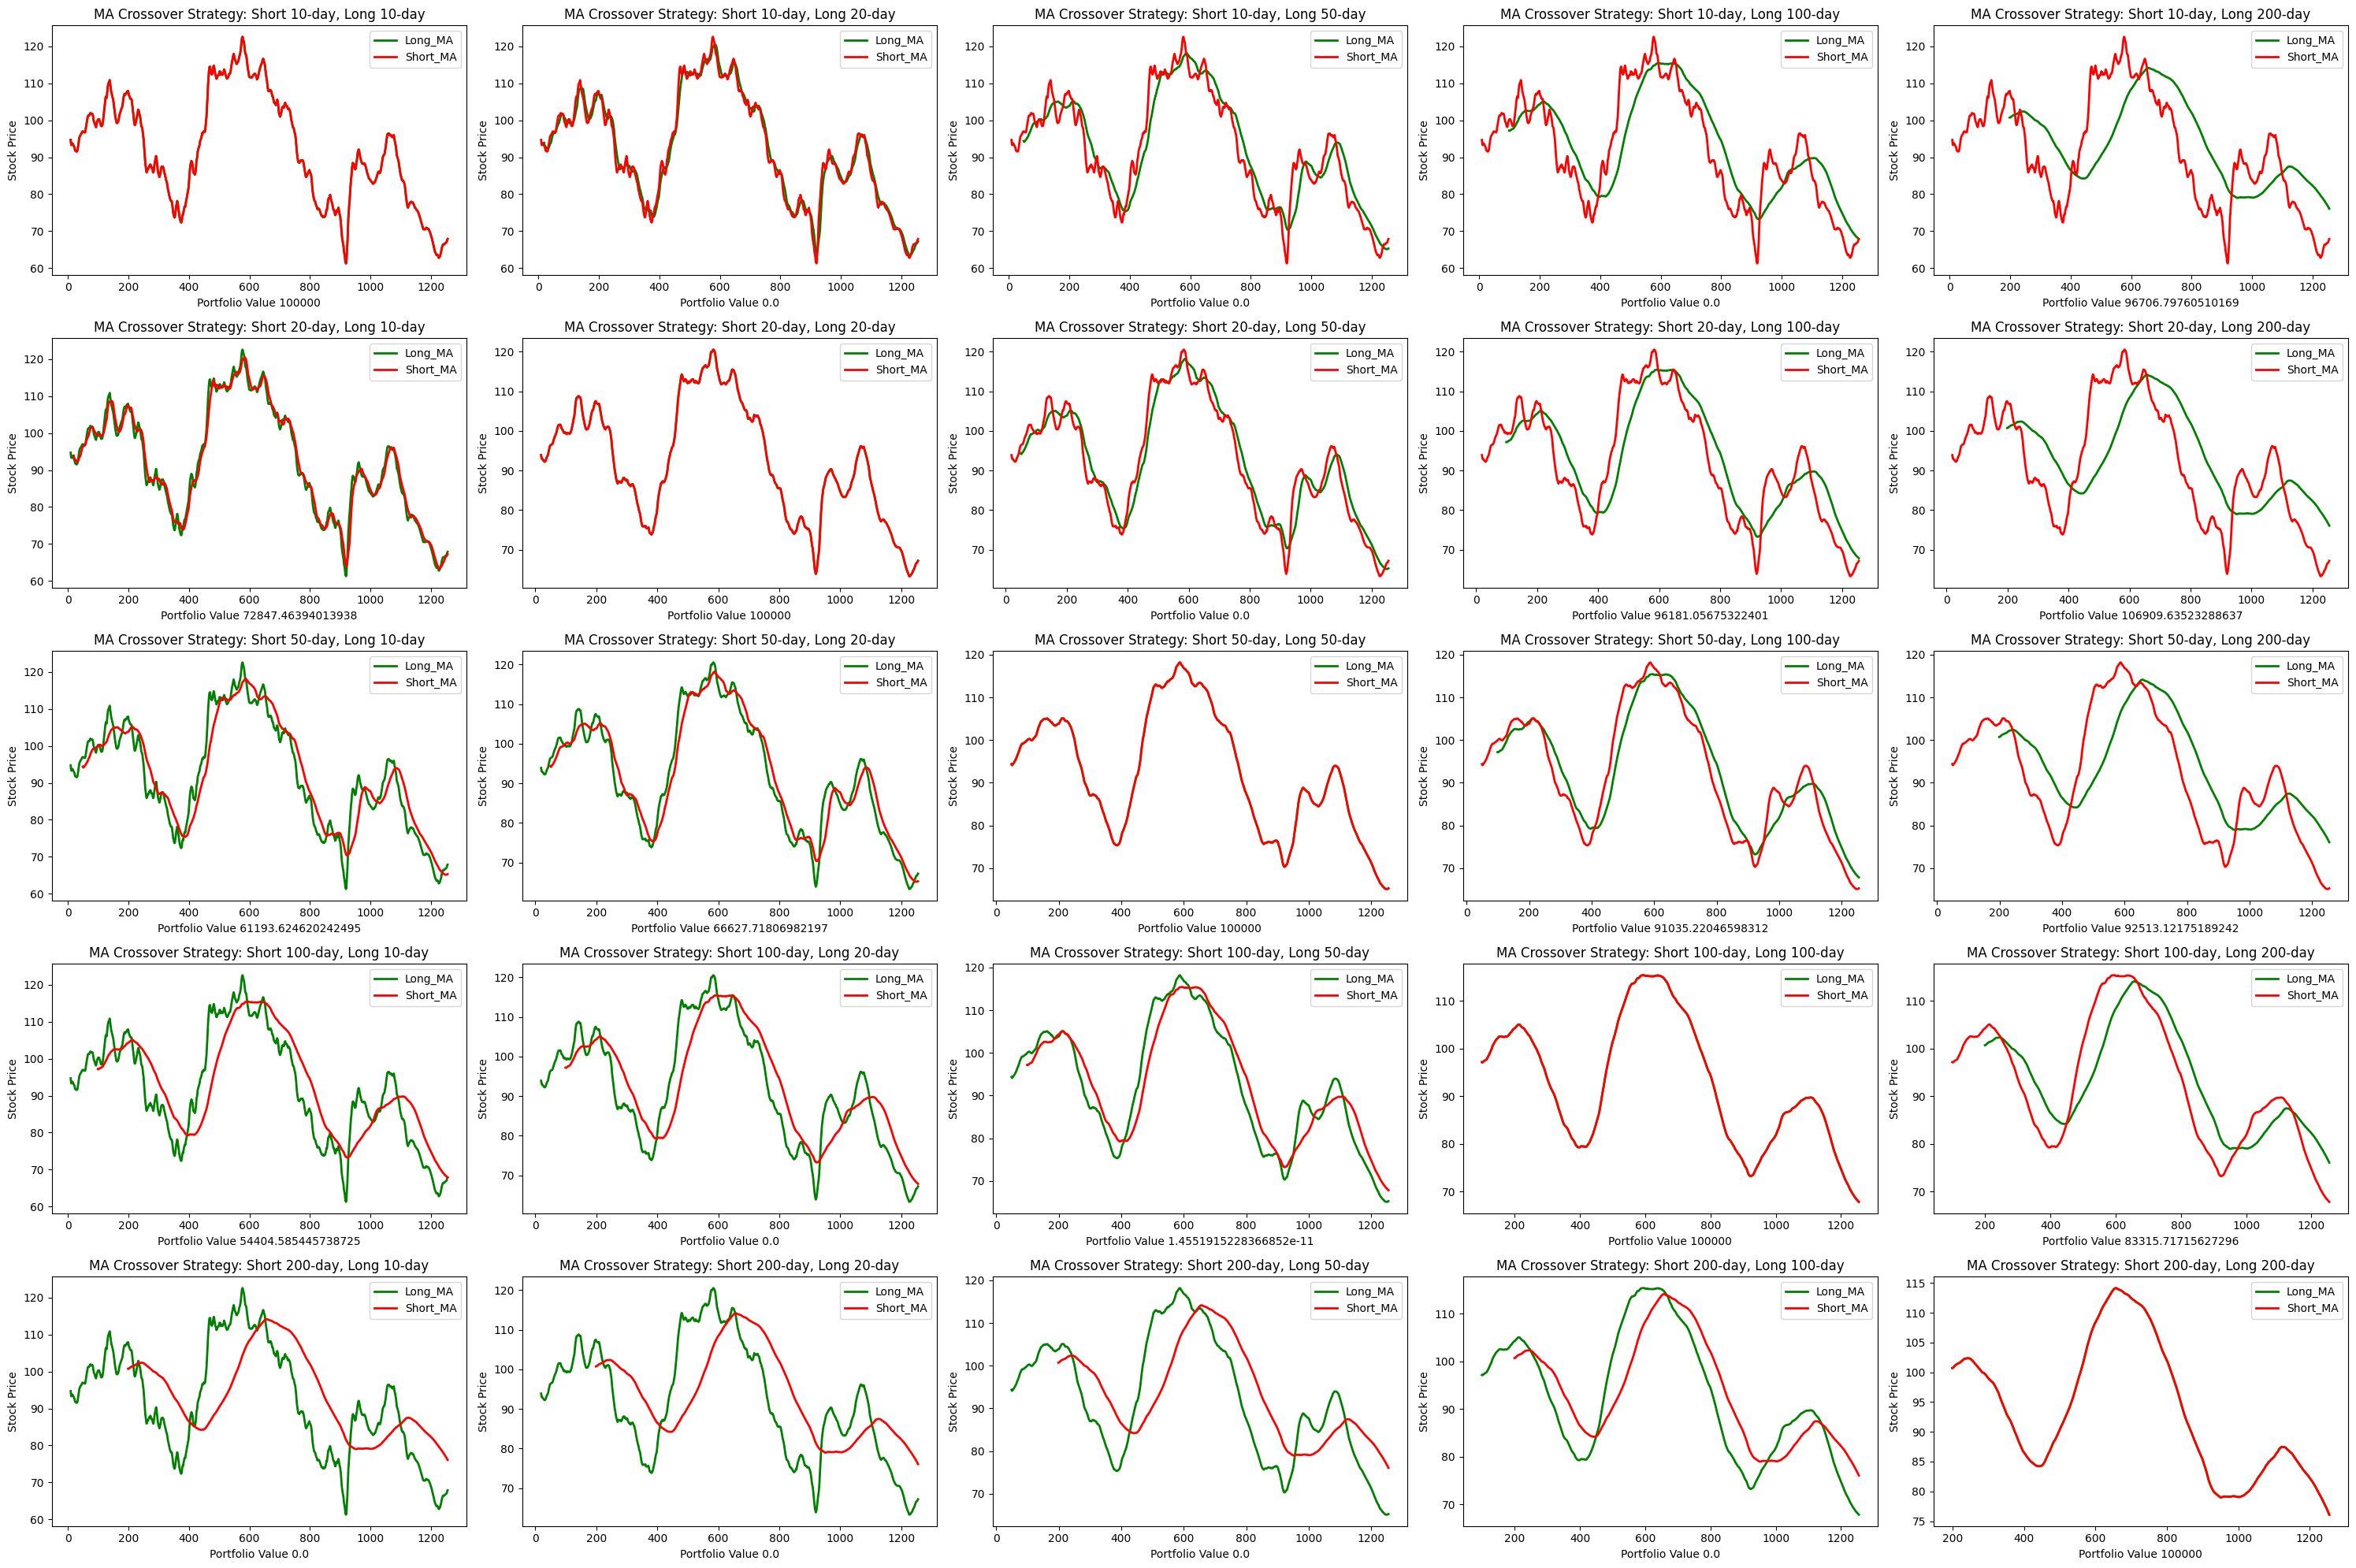

In [18]:
initial_balance = 100000
risk_per_trade = 0.1  # Risk per trade (2% of total account balance)

fig, axs = plt.subplots(5, 5, figsize=(30, 20))
axs = axs.ravel()

for j, (short_window, long_window) in enumerate(param_combinations):
    # Calculate short and long moving averages
    balance = initial_balance
    balance_history = []
    shares_bought = 0

    signals = []
    position = None

    entry_price = 0
    position_value = 0
    position_size = 0

    df['Short_MA'] = df['Close/Last'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close/Last'].rolling(window=long_window).mean()

    for i in range(len(df)):
        if df['Short_MA'][i] > df['Long_MA'][i] and position != 'Buy':
            signals.append('Buy')
            position = 'Buy'
        elif df['Short_MA'][i] < df['Long_MA'][i] and position != 'Sell':
            signals.append('Sell')
            position = 'Sell'
        else:
            signals.append('Hold')

    df['Signal'] = signals

    for i in range(len(df)):
        if df['Signal'][i] == 'Hold':
            balance_history.append([df['Signal'][i], i, balance])
        elif df['Signal'][i] == 'Buy':
            # max_loss_per_trade = balance * risk_per_trade  # Maximum allowed loss per trade
            # stop_loss_price = df['Close/Last'][i] - max_loss_per_trade * df['Close/Last'][i]
            
            # # Calculate position size based on stop-loss order
            # position_size = max_loss_per_trade / (df['Close/Last'][i] - stop_loss_price)
            # position_value = position_size * df['Close/Last'][i]            

            # balance -= position_value
            # # print("Balance:", balance)
            # position = 'Buy'
            # entry_price = df['Close/Last'][i]
            # balance_history.append([df['Signal'][i], i, balance])
            
            shares_bought = balance/df['Close/Last'][i]
            balance -= shares_bought*df['Close/Last'][i]
            balance_history.append([df['Signal'][i], i, balance])
        else:
            balance += shares_bought*df['Close/Last'][i]
            balance_history.append([df['Signal'][i], i, balance])

        #     if position is not None:
        #         # Calculate trade profit/loss
        #             exit_price = df['Close/Last'][i]  # Exit price for the trade
        #             trade_profit_loss = (exit_price - entry_price) * position_size
                    
        #             # Update balance and position
        #             balance += position_value + trade_profit_loss
        #             position = 'Sell'
    
        # # Calculate current balance including open position value
        # balance_with_position = balance + position_value if position is not None else balance
        # balance_history.append([df['Signal'][i], i, balance_with_position])

    axs[j].plot(df['Long_MA'], label='Long_MA', color='green', linewidth=2)
    axs[j].plot(df['Short_MA'], label='Short_MA', color='red', linewidth=2)
    
    axs[j].set_xlabel(f'Portfolio Value {balance_history[-1][2]}')
    axs[j].set_ylabel('Stock Price')
    axs[j].set_title(f'MA Crossover Strategy: Short {short_window}-day, Long {long_window}-day')
    axs[j].legend()
        
    total_return = balance_history[-1][2]
    
    if total_return > best_total_return:
        best_total_return = total_return
        best_params = (short_window, long_window)

plt.tight_layout()
plt.show()

## Optimal Result

In [16]:
print(f'Best Parameters (Short MA, Long MA): {best_params}')
print(f'Best Total Return: {best_total_return:.2f}')

Best Parameters (Short MA, Long MA): (20, 200)
Best Total Return: 106909.64


# Misc.

## Figuring it out

In [6]:
signals = []
position = None
df['Short_MA'] = df['Close/Last'].rolling(window=50).mean()
df['Long_MA'] = df['Close/Last'].rolling(window=200).mean()

for i in range(len(df)):
    if df['Short_MA'][i] > df['Long_MA'][i] and position != 'Buy':
        signals.append('Buy')
        position = 'Buy'
    elif df['Short_MA'][i] < df['Long_MA'][i] and position != 'Sell':
        signals.append('Sell')
        position = 'Sell'
    else:
        signals.append('Hold')

df['Signal'] = signals

In [10]:
initial_balance = 100000
balance = initial_balance
position = None
balance_history = []
shares_bought = 0

risk_per_trade = 0.02
entry_price = 0
position_value = 0
position_size = 0

for i in range(len(df)):
    if df['Signal'][i] == 'Hold':
        balance_history.append([df['Signal'][i], i, balance])
    elif df['Signal'][i] == 'Buy':
        max_loss_per_trade = balance * risk_per_trade  # Maximum allowed loss per trade
        print('max_loss: ', max_loss_per_trade)        
        stop_loss_price = df['Close/Last'][i] - (risk_per_trade * df['Close/Last'][i])
        print('stop_loss_price, stock_price', stop_loss_price, df['Close/Last'][i])
        
        # Calculate position size based on stop-loss order
        position_size = balance / (df['Close/Last'][i] - stop_loss_price)
        print("position_size: ", position_size)
        position_value = position_size * df['Close/Last'][i]
        print("position_value: ", position_value)

        balance -= position_value        
        position = 'Buy'
        entry_price = df['Close/Last'][i]
        balance_history.append([df['Signal'][i], i, balance])
        
        # shares_bought = balance/df['Close/Last'][i]
        # balance -= shares_bought*df['Close/Last'][i]
        # balance_history.append([df['Signal'][i], i, balance])
    else:
        # balance += shares_bought*df['Close/Last'][i]
        # balance_history.append([df['Signal'][i], i, balance])

        if position is not None:
            # Calculate trade profit/loss
            exit_price = df['Close/Last'][i]  # Exit price for the trade
            trade_profit_loss = (exit_price - entry_price) * position_size
            
            # Update balance and position
            balance += position_value + trade_profit_loss
            position = 'Sell'

    # Calculate current balance including open position value
    balance_with_position = balance + position_value if position is not None else balance
    balance_history.append([df['Signal'][i], i, balance_with_position])

max_loss:  2000.0
stop_loss_price, stock_price 102.9392 105.04
position_size:  47600.91393754745
position_value:  4999999.999999984
max_loss:  -5587.58568164507
stop_loss_price, stock_price 91.2478 93.11
position_size:  -150026.46551511827
position_value:  -13968964.204112662
max_loss:  -74029.65924964205
stop_loss_price, stock_price 91.7476 93.62
position_size:  -1976865.5001506645
position_value:  -185074148.12410522


## Creating Moving Averages (50 and 200 window sizez)

In [5]:


# df['50_MA'] = df['Close/Last'].rolling(window=50).mean()
# df['200_MA'] = df['Close/Last'].rolling(window=200).mean()

# signals = []
# position = None

# for i in range(len(df)):
#     if df['50_MA'][i] > df['200_MA'][i] and position != 'Buy':
#         signals.append('Buy')
#         position = 'Buy'
#     elif df['50_MA'][i] < df['200_MA'][i] and position != 'Sell':
#         signals.append('Sell')
#         position = 'Sell'
#     else:
#         signals.append('Hold')

# df['Signal'] = signals

## Plotting Test

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(df['Close/Last'], label='Close', color='blue', linewidth=2)
# plt.plot(df['50_MA'], label='50_MA', color='red', linewidth=2)
# plt.plot(df['200_MA'], label='200_MA', color='green', linewidth=2)

# plt.xlabel('Index')
# plt.ylabel('Price')
# plt.title('Price and Moving Averages')

# plt.legend()
# plt.grid(True)

# plt.show()

## Testing Trading Strategy

In [19]:
# initial_balance = 100000
# balance = initial_balance
# position = None
# balance_history = []
# shares_bought = 0

# for i in range(len(df)):
#     if df['Signal'][i] == 'Hold':
#         balance_history.append([df['Signal'][i], i, balance])                
#     elif df['Signal'][i] == 'Buy':
#         shares_bought = balance/df['Close/Last'][i]
#         balance -= shares_bought*df['Close/Last'][i]
#         balance_history.append([df['Signal'][i], i, balance+shares_bought*df['Close/Last'][i]])
#     else:
#         balance += shares_bought*df['Close/Last'][i]
#         balance_history.append([df['Signal'][i], i, balance])        
# balance_history[-1]